In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

C:\Users\41162395\Anaconda3\envs\image_cluster\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# path = r"D:\Downloads\flower_color_images\flowers\flowers"
path = r"D:\Downloads\flower_color_images\flower_images\flower_images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)
       

In [3]:
# view the first 10 flower entries
print(flowers[:10])

['0001.png', '0002.png', '0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png']


In [4]:
# load the image as a 224x224 array
img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)
(224, 224, 3)

(224, 224, 3)


(224, 224, 3)

In [5]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
(1, 224, 224, 3)

(1, 224, 224, 3)


(1, 224, 224, 3)

In [6]:
x = preprocess_input(reshaped_img)

In [7]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [8]:
features = model.predict(x)
print(features.shape)
(1,4096)

(1, 4096)


(1, 4096)

In [9]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [10]:
data = {}
p = r"flower_features.pkl"

# lop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

# get the unique labels (from the flower_labels.csv)
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

In [11]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [12]:
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)

KMeans(n_clusters=10, random_state=22)

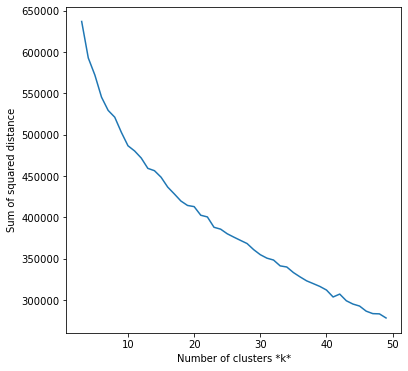

In [14]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');